In [1]:
! pip install --upgrade imutils
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -d /content/shape_predictor_68_face_landmarks.dat.bz2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-08 18:33:21--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  52.9MB/s    in 1.2s    

2022-12-08 18:33:22 (52.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [2]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
from os import listdir
from google.colab.patches import cv2_imshow
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

In [4]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [5]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
pretrained_dlib_detector = "/content/shape_predictor_68_face_landmarks.dat"
detector = detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor(pretrained_dlib_detector)

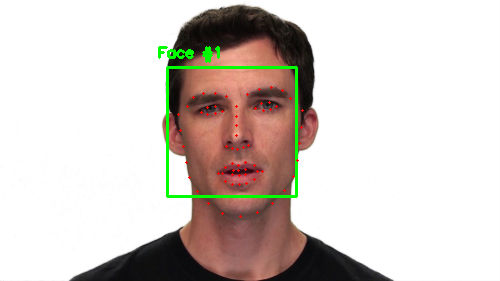

In [7]:
from IPython.display import clear_output

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

video_speech_path = '/content/drive/MyDrive/CV Project Workspace/Project_Code/Data/RAVDESS/Video_Speech/'

# restrict the number of examples/data
emotion_data = np.zeros([8, 1700, 68*68])
emotion_ids = [0, 0, 0, 0, 0, 0, 0, 0]


NUM_VIDEOS = 60*24

video_num = 0
for actor in listdir(video_speech_path):
  ### test use
  # if actor_num == 1:
  #   break
  # actor_num += 1
  ###
  for video in listdir(video_speech_path+actor):
    print('processing...' , video_num/NUM_VIDEOS)
    clear_output(wait=True)
    # filter and only process speech video
    if video[:5] != '02-01':
      continue
    
    ### test use
    # if video_num == 1:
    #   break
    video_num += 1
    ###

    # found video 
    video_path = video_speech_path + actor + "/" + video
    cap = cv2.VideoCapture(video_path)
    # video's emotion
    emotion_label = int(video[7])-1

    # down sampling the amount of frames
    down_sample_rate = 15
    frame_num = 0

    while True:
      success, img = cap.read()

      if not success:
        break

      if frame_num % down_sample_rate != 0:
        frame_num += 1
        continue
      
      # load the input image, resize it, and convert it to grayscale
      image = imutils.resize(img, width=500)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # detect faces in the grayscale image
      rects = detector(gray, 1)


      # loop over the face detections
      for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
          cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
      # show the output image with the face detections + facial landmarks
      cv2_imshow(image)
      cv2.waitKey(0)

      break
    break
  break